### Rishu Raj Singh (2023AIB2080)

## Configuration 2

In [1]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 904.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.9 MB/s eta 0:00:00


In [2]:
import math
from dataclasses import dataclass
import os
import numpy as np
import sacrebleu
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas
torch.manual_seed(0)
import random
random.seed(0)
import  pathlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchinfo import summary

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [3]:
SRC = "en"
TRG = "fr"
en_vocab_size = 8000
fr_vocab_size = 8000
vocab_sizes = {"en": en_vocab_size, "fr": fr_vocab_size}
max_seq_len = 72

In [4]:
full_set = pandas.read_csv("/kaggle/input/dataset-5/eng_-french.csv")

temp_train_set, test_set = train_test_split(full_set, test_size=0.3, random_state=42)
full_train_set, valid_set = train_test_split(temp_train_set, test_size=0.1, random_state=42)

print(len(full_train_set), len(valid_set), len(test_set))

110640 12294 52687


In [5]:
full_train_set.head(3)

,English words/sentences,French words/sentences
1660,That hurts.,Ça fait mal.
89279,I can't function without you.,Je n'arrive pas à fonctionner sans toi.
144858,Let's talk about what you did in Boston.,Parlons de ce que tu as fait à Boston.


In [6]:
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, decoders

# This library has been used only for tokenization purpose because French sentences contains 
# distinct type of character which is diificult to capture normally.

def get_tokenizers(dataset, train_set_size):
    en_sentences = dataset['English words/sentences'].iloc[:train_set_size].tolist()
    fr_sentences = dataset['French words/sentences'].iloc[:train_set_size].tolist()

    # Write English and French sentences to temporary files
    en_file = 'temp_en_sentences.txt'
    fr_file = 'temp_fr_sentences.txt'
    with open(en_file, 'w', encoding='utf-8') as f_en, open(fr_file, 'w', encoding='utf-8') as f_fr:
        for en_sent, fr_sent in zip(en_sentences, fr_sentences):
            f_en.write(en_sent + '\n')
            f_fr.write(fr_sent + '\n')

    # Initialize a tokenizer
    en_tokenizer = Tokenizer(models.BPE())
    fr_tokenizer = Tokenizer(models.BPE())

    # Customize pre-tokenization and decoding
    en_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    fr_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    en_tokenizer.decoder = decoders.BPEDecoder()
    fr_tokenizer.decoder = decoders.BPEDecoder()

    en_tokenizer.train([en_file], trainer=trainers.BpeTrainer(vocab_size=en_vocab_size, special_tokens=["<pad>"]))
    fr_tokenizer.train([fr_file], trainer=trainers.BpeTrainer(vocab_size=fr_vocab_size, special_tokens=["<pad>"]))

    # Define the tokenization and detokenization functions
    tokenizers = {"en": lambda sent: en_tokenizer.encode(sent).ids, "fr": lambda sent: fr_tokenizer.encode(sent).ids}
    detokenizers = {"en": lambda ids: ' '.join([en_tokenizer.id_to_token(id) for id in ids]), 
                    "fr": lambda ids: ' '.join([fr_tokenizer.id_to_token(id) for id in ids])}
    # Cleanup temporary files
    os.remove(en_file)
    os.remove(fr_file)

    return tokenizers, detokenizers


In [7]:
tokenizers, detokenizers = get_tokenizers(full_train_set, len(full_set))
print(tokenizers['fr']("De quoi ai-je l'air ?"))
print(tokenizers['en']('How do I look?'))

# indexes of special symbols
UNK, BOS, EOS, PAD = 0, 1, 2, 3







[645, 238, 106, 10, 167, 63, 6, 488, 25]
[238, 114, 32, 274, 23]


In [8]:
def tokenize_dataset(dataset):
    """
    Tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences.
    """
    if SRC == "en":
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for src_text, trg_text in dataset]
    else:
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for trg_text, src_text in dataset]
    

class TranslationDataset(Dataset):
    'create a dataset for torch.utils.data.DataLoader() '
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def pad_sequence(batch):
    'collate function for padding sentences such that all \
    the sentences in the batch have the same length'
    src_seqs  = [src for src, trg in batch]
    trg_seqs  = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs,
                                batch_first=True, padding_value = PAD)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs,
                                batch_first=True, padding_value = PAD)
    return src_padded, trg_padded

In [9]:
batch_size = 16

class Dataloaders:
    'Dataloaders contains train_loader, test_loader and valid_loader for training and evaluation '
    def __init__(self):
        # train_set = list(full_train_set)[0:train_set_size]
        train_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in full_train_set.iterrows()]
        valid_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in valid_set.iterrows()]
        test_set_1 = [(row['English words/sentences'], row['French words/sentences']) for index, row in test_set.iterrows()]
        # print(train_set)
        train_dataset = TranslationDataset(tokenize_dataset(train_set_1))
        valid_dataset = TranslationDataset(tokenize_dataset(valid_set_1))
        test_dataset  = TranslationDataset(tokenize_dataset(test_set_1))

        # each batch returned by dataloader will be padded such that all the texts in
        # that batch have the same length as the longest text in that batch
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn = pad_sequence)

        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

        self.valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

In [10]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) # get batch size
        # 1) Linear projections to get the multi-head query, key and value tensors
        # x_query, x_key, x_value dimension: nbatch * seq_len * d_embed
        # LHS query, key, value dimensions: nbatch * h * seq_len * d_k
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        # 2) Attention
        # scores has dimensions: nbatch * h * seq_len * seq_len
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        # 3) Mask out padding tokens and future tokens
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        # p_atten dimensions: nbatch * h * seq_len * seq_len
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        # x dimensions: nbatch * h * seq_len * d_k
        x = torch.matmul(p_atten, value)
        # x now has dimensions:nbtach * seq_len * d_embed
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x) # final linear layer


class ResidualConnection(nn.Module):
    '''residual connection: x + dropout(sublayer(layernorm(x))) '''
    def __init__(self, dim, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, sublayer):
        return x + self.drop(sublayer(self.norm(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, d_embed, max_seq_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_embed = d_embed
        # Compute the positional encodings in log space
        pe = torch.zeros(max_seq_len, d_embed)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_embed, 2).float() * (-math.log(10000.0) / d_embed))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Add batch dimension
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encodings to the input embeddings
        return x + self.pe[:, :x.size(1), :]


class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed) 
        self.pos_embed = PositionalEncoding(config.d_embed, config.max_seq_len)
        # self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x = self.pos_embed(x)
        x = self.dropout(x)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)



class EncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = PositionalEncoding(config.d_embed, config.max_seq_len)
        # self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed)) 
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)
    
    def future_mask(self, seq_len):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg)
        x = self.pos_embed(x)
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout) 
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys and values are from the encoder output
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)


In [11]:
@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    # d_ff is the dimension of the fully-connected  feed-forward layer
    d_ff: int
    # h is the number of attention head
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(DEVICE)

    # initialize model parameters
    # it seems that this initialization is very important!
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    return model

def make_batch_input(x, y):
        src = x.to(DEVICE)
        trg_in = y[:, :-1].to(DEVICE)
        trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
        src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
        trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
        return src, trg_in, trg_out, src_pad_mask, trg_pad_mask

In [12]:
def translate(model, x):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[BOS]*dB]).view(dB, 1).to(DEVICE)
        x_pad_mask = (x == PAD).view(x.size(0), 1, 1, x.size(-1)).to(DEVICE)
        memory = model.encoder(x, x_pad_mask)
        for i in range(max_seq_len):
            y_pad_mask = (y == PAD).view(y.size(0), 1, 1, y.size(-1)).to(DEVICE)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(DEVICE)
    return y

def remove_pad(sent):
    '''truncate the sentence if BOS is in it,
     otherwise simply remove the padding tokens at the end'''
    if sent.count(EOS)>0:
      sent = sent[0:sent.index(EOS)+1]
    while sent and sent[-1] == PAD:
            sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids):
    'convert a tokenized sentence (a list of numbers) to a literal string'
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids)
    return detokenizer(sentence_ids).replace("<bos>", "")\
           .replace("<eos>", "").strip().replace(" .", ".")

def evaluate(model, dataloader, num_batch=None):
    'evaluate the model, and compute the BLEU score'
    model.eval()
    refs, cans, bleus = [], [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            translation = translate(model, src)
            trg_out = trg_out.view(x.size(0), -1)
            refs = refs + [decode_sentence(detokenizers[TRG], trg_out[i]) for i in range(len(src))]
            cans = cans + [decode_sentence(detokenizers[TRG], translation[i]) for i in range(len(src))]
            if num_batch and idx>=num_batch:
                break
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)
        # print some examples
        for i in range(3):
            print(f'src:  {decode_sentence(detokenizers[SRC], src[i])}')
            print(f'trg:  {decode_sentence(detokenizers[TRG], trg_out[i])}')
            print(f'pred: {decode_sentence(detokenizers[TRG], translation[i])}')
        return np.mean(bleus)

In [13]:
def train_epoch(model, dataloaders):
    model.train()
    grad_norm_clip = 1.0
    losses = []
    num_batches = len(dataloaders.train_loader)
    pbar = tqdm(enumerate(dataloaders.train_loader), total=num_batches)
    for idx, (x, y) in pbar:
        optimizer.zero_grad()
        src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)
        pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
        pred = pred.view(-1, pred.size(-1))
        loss = loss_fn(pred, trg_out).to(DEVICE)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        losses.append(loss.item())
        # report progress
        if idx > 0 and idx % 50 == 0:
            pbar.set_description(f'train loss={loss.item():.3f}')
    return np.mean(losses)


def validate(model, dataloder):
    'compute the validation loss'
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloder):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = pred.view(-1, pred.size(-1))
            losses.append(loss_fn(pred, trg_out).item())
    return np.mean(losses)

def compute_accuracy(model, dataloader):
    'compute the validation accuracy'
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x, y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = torch.argmax(pred, dim=-1)  # Get the indices of the maximum value along the last dimension
            # Flatten trg_out to match pred for comparison
            trg_out_flat = trg_out.view(-1)
            correct = (pred.view(-1) == trg_out_flat).sum().item()
            total_correct += correct
            total_samples += trg_out_flat.size(0)
    accuracy = total_correct / total_samples
    return accuracy

In [14]:
config = ModelConfig(encoder_vocab_size = vocab_sizes[SRC],
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=128,
                     d_ff=1024,
                     h=8,
                     N_encoder=3,
                     N_decoder=3,
                     max_seq_len=max_seq_len,
                     dropout=0.1
                     )


# Initialize model
model = make_model(config)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

dataloaders = Dataloaders()

# Set up training loop
num_epochs = 200
train_losses = []
valid_losses = []
valid_accuracies = []

for epoch in range(num_epochs):

    best_valid_loss = float('inf')
    train_size = len(dataloaders.train_loader) * batch_size
    train_loss = train_epoch(model, dataloaders)
    train_losses.append(train_loss)
    valid_loss = validate(model, dataloaders.valid_loader)
    valid_losses.append(valid_loss)

    # Calculate validation accuracy
    valid_accuracy = compute_accuracy(model, dataloaders.valid_loader)
    valid_accuracies.append(valid_accuracy)


    print(f'ep:{epoch+1} train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}, valid_accuracy={valid_accuracy:.5f}')
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss


# print("train set examples:")
# train_bleu = evaluate(model, dataloaders.train_loader, 20)
# print("validation set examples:")
# valid_bleu = evaluate(model, dataloaders.valid_loader)
# print("test set examples:")
# test_bleu  = evaluate(model, dataloaders.test_loader)


train loss=2.352: 100%|██████████| 6915/6915 [03:07<00:00, 36.86it/s]


ep:1 train_loss=2.80335, valid_loss=2.20550, valid_accuracy=0.65147


train loss=2.309: 100%|██████████| 6915/6915 [03:09<00:00, 36.51it/s]


ep:2 train_loss=2.09061, valid_loss=1.88895, valid_accuracy=0.68677


train loss=1.670: 100%|██████████| 6915/6915 [03:07<00:00, 36.92it/s]


ep:3 train_loss=1.83442, valid_loss=1.66971, valid_accuracy=0.70927


train loss=1.525: 100%|██████████| 6915/6915 [03:09<00:00, 36.50it/s]


ep:4 train_loss=1.64671, valid_loss=1.49543, valid_accuracy=0.73239


train loss=1.535: 100%|██████████| 6915/6915 [03:08<00:00, 36.76it/s]


ep:5 train_loss=1.48570, valid_loss=1.35020, valid_accuracy=0.75407


train loss=1.703: 100%|██████████| 6915/6915 [03:08<00:00, 36.67it/s]


ep:6 train_loss=1.34856, valid_loss=1.24331, valid_accuracy=0.76912


train loss=1.481: 100%|██████████| 6915/6915 [03:09<00:00, 36.57it/s]


ep:7 train_loss=1.23223, valid_loss=1.12956, valid_accuracy=0.78564


train loss=0.936: 100%|██████████| 6915/6915 [03:09<00:00, 36.41it/s]


ep:8 train_loss=1.13440, valid_loss=1.05448, valid_accuracy=0.79908


train loss=1.051: 100%|██████████| 6915/6915 [03:10<00:00, 36.25it/s]


ep:9 train_loss=1.05094, valid_loss=0.99603, valid_accuracy=0.80927


train loss=1.231: 100%|██████████| 6915/6915 [03:09<00:00, 36.41it/s]


ep:10 train_loss=0.97995, valid_loss=0.94439, valid_accuracy=0.81654


train loss=0.935: 100%|██████████| 6915/6915 [03:10<00:00, 36.37it/s]


ep:11 train_loss=0.92490, valid_loss=0.90057, valid_accuracy=0.82379


train loss=0.749: 100%|██████████| 6915/6915 [03:09<00:00, 36.44it/s]


ep:12 train_loss=0.87427, valid_loss=0.86160, valid_accuracy=0.82863


train loss=0.883: 100%|██████████| 6915/6915 [03:07<00:00, 36.90it/s]


ep:13 train_loss=0.83272, valid_loss=0.82702, valid_accuracy=0.83469


train loss=0.926: 100%|██████████| 6915/6915 [03:08<00:00, 36.73it/s]


ep:14 train_loss=0.79309, valid_loss=0.80661, valid_accuracy=0.83862


train loss=0.730: 100%|██████████| 6915/6915 [03:09<00:00, 36.46it/s]


ep:15 train_loss=0.76313, valid_loss=0.78447, valid_accuracy=0.84192


train loss=0.917: 100%|██████████| 6915/6915 [03:08<00:00, 36.64it/s]


ep:16 train_loss=0.73672, valid_loss=0.77036, valid_accuracy=0.84456


train loss=0.528: 100%|██████████| 6915/6915 [03:08<00:00, 36.72it/s]


ep:17 train_loss=0.70950, valid_loss=0.75576, valid_accuracy=0.84847


train loss=0.586: 100%|██████████| 6915/6915 [03:07<00:00, 36.85it/s]


ep:18 train_loss=0.68630, valid_loss=0.73902, valid_accuracy=0.85035


train loss=0.604: 100%|██████████| 6915/6915 [03:09<00:00, 36.57it/s]


ep:19 train_loss=0.66561, valid_loss=0.72575, valid_accuracy=0.85172


train loss=1.021: 100%|██████████| 6915/6915 [03:12<00:00, 35.91it/s]


ep:20 train_loss=0.64771, valid_loss=0.71655, valid_accuracy=0.85422


train loss=0.490: 100%|██████████| 6915/6915 [03:12<00:00, 35.97it/s]


ep:21 train_loss=0.62897, valid_loss=0.70661, valid_accuracy=0.85680


train loss=0.693: 100%|██████████| 6915/6915 [03:13<00:00, 35.81it/s]


ep:22 train_loss=0.61415, valid_loss=0.70167, valid_accuracy=0.85754


train loss=0.426: 100%|██████████| 6915/6915 [03:12<00:00, 35.84it/s]


ep:23 train_loss=0.59929, valid_loss=0.69127, valid_accuracy=0.85966


train loss=0.461: 100%|██████████| 6915/6915 [03:12<00:00, 35.86it/s]


ep:24 train_loss=0.58455, valid_loss=0.68293, valid_accuracy=0.86185


train loss=0.551: 100%|██████████| 6915/6915 [03:15<00:00, 35.40it/s]


ep:25 train_loss=0.57139, valid_loss=0.67443, valid_accuracy=0.86288


train loss=0.488: 100%|██████████| 6915/6915 [03:12<00:00, 35.84it/s]


ep:26 train_loss=0.56073, valid_loss=0.67444, valid_accuracy=0.86323


train loss=0.338: 100%|██████████| 6915/6915 [03:14<00:00, 35.60it/s]


ep:27 train_loss=0.54746, valid_loss=0.66608, valid_accuracy=0.86472


train loss=0.760: 100%|██████████| 6915/6915 [03:15<00:00, 35.39it/s]


ep:28 train_loss=0.53700, valid_loss=0.66077, valid_accuracy=0.86539


train loss=0.329: 100%|██████████| 6915/6915 [03:12<00:00, 36.01it/s]


ep:29 train_loss=0.52571, valid_loss=0.66023, valid_accuracy=0.86612


train loss=0.511: 100%|██████████| 6915/6915 [03:13<00:00, 35.75it/s]


ep:30 train_loss=0.51615, valid_loss=0.65209, valid_accuracy=0.86724


train loss=0.737: 100%|██████████| 6915/6915 [03:13<00:00, 35.81it/s]


ep:31 train_loss=0.50631, valid_loss=0.64756, valid_accuracy=0.86730


train loss=0.412: 100%|██████████| 6915/6915 [03:13<00:00, 35.82it/s]


ep:32 train_loss=0.49976, valid_loss=0.64496, valid_accuracy=0.86960


train loss=0.362: 100%|██████████| 6915/6915 [03:11<00:00, 36.17it/s]


ep:33 train_loss=0.49033, valid_loss=0.64363, valid_accuracy=0.86937


train loss=0.450: 100%|██████████| 6915/6915 [03:10<00:00, 36.27it/s]


ep:34 train_loss=0.48122, valid_loss=0.63902, valid_accuracy=0.87024


train loss=0.352: 100%|██████████| 6915/6915 [03:12<00:00, 35.88it/s]


ep:35 train_loss=0.47347, valid_loss=0.63140, valid_accuracy=0.87111


train loss=0.589: 100%|██████████| 6915/6915 [03:12<00:00, 35.90it/s]


ep:36 train_loss=0.46804, valid_loss=0.63456, valid_accuracy=0.87111


train loss=0.389: 100%|██████████| 6915/6915 [03:11<00:00, 36.18it/s]


ep:37 train_loss=0.45976, valid_loss=0.63481, valid_accuracy=0.87217


train loss=0.405: 100%|██████████| 6915/6915 [03:10<00:00, 36.30it/s]


ep:38 train_loss=0.45393, valid_loss=0.62544, valid_accuracy=0.87266


train loss=0.415: 100%|██████████| 6915/6915 [03:09<00:00, 36.57it/s]


ep:39 train_loss=0.44623, valid_loss=0.62569, valid_accuracy=0.87309


train loss=0.455: 100%|██████████| 6915/6915 [03:10<00:00, 36.29it/s]


ep:40 train_loss=0.44071, valid_loss=0.62182, valid_accuracy=0.87333


train loss=0.307: 100%|██████████| 6915/6915 [03:14<00:00, 35.61it/s]


ep:41 train_loss=0.43466, valid_loss=0.62444, valid_accuracy=0.87420


train loss=0.304: 100%|██████████| 6915/6915 [03:12<00:00, 35.88it/s]


ep:42 train_loss=0.42874, valid_loss=0.62255, valid_accuracy=0.87449


train loss=0.378: 100%|██████████| 6915/6915 [03:11<00:00, 36.20it/s]


ep:43 train_loss=0.42375, valid_loss=0.62134, valid_accuracy=0.87534


train loss=0.389: 100%|██████████| 6915/6915 [03:10<00:00, 36.28it/s]


ep:44 train_loss=0.41844, valid_loss=0.62117, valid_accuracy=0.87626


train loss=0.277: 100%|██████████| 6915/6915 [03:13<00:00, 35.80it/s]


ep:45 train_loss=0.41335, valid_loss=0.62149, valid_accuracy=0.87480


train loss=0.467: 100%|██████████| 6915/6915 [03:10<00:00, 36.28it/s]


ep:46 train_loss=0.40771, valid_loss=0.61701, valid_accuracy=0.87579


train loss=0.369: 100%|██████████| 6915/6915 [03:10<00:00, 36.35it/s]


ep:47 train_loss=0.40254, valid_loss=0.61999, valid_accuracy=0.87592


train loss=0.459: 100%|██████████| 6915/6915 [03:10<00:00, 36.30it/s]


ep:48 train_loss=0.39892, valid_loss=0.61701, valid_accuracy=0.87742


train loss=0.400: 100%|██████████| 6915/6915 [03:11<00:00, 36.05it/s]


ep:49 train_loss=0.39435, valid_loss=0.61671, valid_accuracy=0.87729


train loss=0.403: 100%|██████████| 6915/6915 [03:11<00:00, 36.14it/s]


ep:50 train_loss=0.38929, valid_loss=0.61694, valid_accuracy=0.87809


train loss=0.347: 100%|██████████| 6915/6915 [03:10<00:00, 36.31it/s]


ep:51 train_loss=0.38496, valid_loss=0.61410, valid_accuracy=0.87792


train loss=0.420: 100%|██████████| 6915/6915 [03:08<00:00, 36.66it/s]


ep:52 train_loss=0.38056, valid_loss=0.61849, valid_accuracy=0.87776


train loss=0.503: 100%|██████████| 6915/6915 [03:10<00:00, 36.38it/s]


ep:53 train_loss=0.37723, valid_loss=0.62090, valid_accuracy=0.87759


train loss=0.328: 100%|██████████| 6915/6915 [03:08<00:00, 36.66it/s]


ep:54 train_loss=0.37318, valid_loss=0.61289, valid_accuracy=0.87868


train loss=0.359: 100%|██████████| 6915/6915 [03:19<00:00, 34.68it/s]


ep:55 train_loss=0.36929, valid_loss=0.61705, valid_accuracy=0.87906


train loss=0.489: 100%|██████████| 6915/6915 [03:17<00:00, 34.98it/s]


ep:56 train_loss=0.36564, valid_loss=0.61829, valid_accuracy=0.87894


train loss=0.184: 100%|██████████| 6915/6915 [03:12<00:00, 35.96it/s]


ep:57 train_loss=0.36209, valid_loss=0.61586, valid_accuracy=0.87894


train loss=0.219: 100%|██████████| 6915/6915 [03:12<00:00, 36.01it/s]


ep:58 train_loss=0.35827, valid_loss=0.61082, valid_accuracy=0.87974


train loss=0.255: 100%|██████████| 6915/6915 [03:13<00:00, 35.74it/s]


ep:59 train_loss=0.35485, valid_loss=0.61194, valid_accuracy=0.88061


train loss=0.400: 100%|██████████| 6915/6915 [03:15<00:00, 35.44it/s]


ep:60 train_loss=0.35203, valid_loss=0.61355, valid_accuracy=0.87962


train loss=0.517: 100%|██████████| 6915/6915 [03:12<00:00, 35.97it/s]


ep:61 train_loss=0.34776, valid_loss=0.61195, valid_accuracy=0.88012


train loss=0.372: 100%|██████████| 6915/6915 [03:14<00:00, 35.50it/s]


ep:62 train_loss=0.34509, valid_loss=0.61712, valid_accuracy=0.88043


train loss=0.296: 100%|██████████| 6915/6915 [03:12<00:00, 35.94it/s]


ep:63 train_loss=0.34153, valid_loss=0.61309, valid_accuracy=0.88051


train loss=0.353: 100%|██████████| 6915/6915 [03:11<00:00, 36.16it/s]


ep:64 train_loss=0.33990, valid_loss=0.61047, valid_accuracy=0.88105


train loss=0.309: 100%|██████████| 6915/6915 [03:12<00:00, 35.98it/s]


ep:65 train_loss=0.33523, valid_loss=0.61474, valid_accuracy=0.88074


train loss=0.222: 100%|██████████| 6915/6915 [03:13<00:00, 35.68it/s]


ep:66 train_loss=0.33395, valid_loss=0.61500, valid_accuracy=0.88054


train loss=0.349: 100%|██████████| 6915/6915 [03:13<00:00, 35.70it/s]


ep:67 train_loss=0.33027, valid_loss=0.61879, valid_accuracy=0.88083


train loss=0.286: 100%|██████████| 6915/6915 [03:11<00:00, 36.19it/s]


ep:68 train_loss=0.32711, valid_loss=0.61028, valid_accuracy=0.88116


train loss=0.493: 100%|██████████| 6915/6915 [03:11<00:00, 36.05it/s]


ep:69 train_loss=0.32565, valid_loss=0.61568, valid_accuracy=0.88108


train loss=0.246: 100%|██████████| 6915/6915 [03:13<00:00, 35.79it/s]


ep:70 train_loss=0.32266, valid_loss=0.61638, valid_accuracy=0.88151


train loss=0.333: 100%|██████████| 6915/6915 [03:12<00:00, 35.94it/s]


ep:71 train_loss=0.31976, valid_loss=0.61708, valid_accuracy=0.88177


train loss=0.447: 100%|██████████| 6915/6915 [03:11<00:00, 36.05it/s]


ep:72 train_loss=0.31700, valid_loss=0.61917, valid_accuracy=0.88267


train loss=0.230: 100%|██████████| 6915/6915 [03:13<00:00, 35.77it/s]


ep:73 train_loss=0.31455, valid_loss=0.61442, valid_accuracy=0.88228


train loss=0.333: 100%|██████████| 6915/6915 [03:13<00:00, 35.78it/s]


ep:74 train_loss=0.31244, valid_loss=0.61355, valid_accuracy=0.88232


train loss=0.305: 100%|██████████| 6915/6915 [03:11<00:00, 36.10it/s]


ep:75 train_loss=0.30983, valid_loss=0.61260, valid_accuracy=0.88241


train loss=0.262: 100%|██████████| 6915/6915 [03:14<00:00, 35.52it/s]


ep:76 train_loss=0.30804, valid_loss=0.61933, valid_accuracy=0.88125


train loss=0.291: 100%|██████████| 6915/6915 [03:12<00:00, 35.94it/s]


ep:77 train_loss=0.30540, valid_loss=0.61902, valid_accuracy=0.88187


train loss=0.317: 100%|██████████| 6915/6915 [03:15<00:00, 35.43it/s]


ep:78 train_loss=0.30241, valid_loss=0.61706, valid_accuracy=0.88337


train loss=0.204: 100%|██████████| 6915/6915 [03:11<00:00, 36.20it/s]


ep:79 train_loss=0.30127, valid_loss=0.61909, valid_accuracy=0.88358


train loss=0.216: 100%|██████████| 6915/6915 [03:13<00:00, 35.70it/s]


ep:80 train_loss=0.29952, valid_loss=0.62077, valid_accuracy=0.88248


train loss=0.296: 100%|██████████| 6915/6915 [03:09<00:00, 36.54it/s]


ep:81 train_loss=0.29653, valid_loss=0.61397, valid_accuracy=0.88304


train loss=0.424: 100%|██████████| 6915/6915 [03:10<00:00, 36.22it/s]


ep:82 train_loss=0.29487, valid_loss=0.61865, valid_accuracy=0.88353


train loss=0.203: 100%|██████████| 6915/6915 [03:10<00:00, 36.38it/s]


ep:83 train_loss=0.29233, valid_loss=0.62476, valid_accuracy=0.88316


train loss=0.283: 100%|██████████| 6915/6915 [03:10<00:00, 36.32it/s]


ep:84 train_loss=0.29050, valid_loss=0.62296, valid_accuracy=0.88309


train loss=0.418: 100%|██████████| 6915/6915 [03:09<00:00, 36.48it/s]


ep:85 train_loss=0.28945, valid_loss=0.62132, valid_accuracy=0.88331


train loss=0.274: 100%|██████████| 6915/6915 [03:13<00:00, 35.66it/s]


ep:86 train_loss=0.28638, valid_loss=0.61865, valid_accuracy=0.88402


train loss=0.380: 100%|██████████| 6915/6915 [03:09<00:00, 36.54it/s]


ep:87 train_loss=0.28406, valid_loss=0.62199, valid_accuracy=0.88324


train loss=0.352: 100%|██████████| 6915/6915 [03:12<00:00, 35.98it/s]


ep:88 train_loss=0.28346, valid_loss=0.62182, valid_accuracy=0.88290


train loss=0.333: 100%|██████████| 6915/6915 [03:08<00:00, 36.78it/s]


ep:89 train_loss=0.28117, valid_loss=0.62507, valid_accuracy=0.88306


train loss=0.304: 100%|██████████| 6915/6915 [03:09<00:00, 36.40it/s]


ep:90 train_loss=0.28013, valid_loss=0.62180, valid_accuracy=0.88413


train loss=0.311: 100%|██████████| 6915/6915 [03:08<00:00, 36.62it/s]


ep:91 train_loss=0.27785, valid_loss=0.62148, valid_accuracy=0.88484


train loss=0.304: 100%|██████████| 6915/6915 [03:09<00:00, 36.57it/s]


ep:92 train_loss=0.27604, valid_loss=0.62300, valid_accuracy=0.88418


train loss=0.226: 100%|██████████| 6915/6915 [03:09<00:00, 36.56it/s]


ep:93 train_loss=0.27429, valid_loss=0.62597, valid_accuracy=0.88412


train loss=0.329: 100%|██████████| 6915/6915 [03:08<00:00, 36.65it/s]


ep:94 train_loss=0.27304, valid_loss=0.62330, valid_accuracy=0.88471


train loss=0.243: 100%|██████████| 6915/6915 [03:09<00:00, 36.40it/s]


ep:95 train_loss=0.27107, valid_loss=0.62201, valid_accuracy=0.88401


train loss=0.281: 100%|██████████| 6915/6915 [03:07<00:00, 36.83it/s]


ep:96 train_loss=0.26892, valid_loss=0.62735, valid_accuracy=0.88332


train loss=0.232: 100%|██████████| 6915/6915 [03:10<00:00, 36.26it/s]


ep:97 train_loss=0.26820, valid_loss=0.62769, valid_accuracy=0.88517


train loss=0.225: 100%|██████████| 6915/6915 [03:07<00:00, 36.80it/s]


ep:98 train_loss=0.26635, valid_loss=0.62643, valid_accuracy=0.88414


train loss=0.351: 100%|██████████| 6915/6915 [03:11<00:00, 36.04it/s]


ep:99 train_loss=0.26585, valid_loss=0.62634, valid_accuracy=0.88457


train loss=0.305: 100%|██████████| 6915/6915 [03:13<00:00, 35.74it/s]


ep:100 train_loss=0.26244, valid_loss=0.62517, valid_accuracy=0.88426


train loss=0.253: 100%|██████████| 6915/6915 [03:18<00:00, 34.78it/s]


ep:101 train_loss=0.26169, valid_loss=0.63132, valid_accuracy=0.88494


train loss=0.248: 100%|██████████| 6915/6915 [03:11<00:00, 36.13it/s]


ep:102 train_loss=0.26030, valid_loss=0.62950, valid_accuracy=0.88384


train loss=0.273: 100%|██████████| 6915/6915 [03:12<00:00, 35.83it/s]


ep:103 train_loss=0.25966, valid_loss=0.62883, valid_accuracy=0.88464


train loss=0.248: 100%|██████████| 6915/6915 [03:11<00:00, 36.10it/s]


ep:104 train_loss=0.25786, valid_loss=0.62944, valid_accuracy=0.88446


train loss=0.243: 100%|██████████| 6915/6915 [03:09<00:00, 36.58it/s]


ep:105 train_loss=0.25572, valid_loss=0.62966, valid_accuracy=0.88489


train loss=0.251: 100%|██████████| 6915/6915 [03:10<00:00, 36.38it/s]


ep:106 train_loss=0.25445, valid_loss=0.62794, valid_accuracy=0.88514


train loss=0.281: 100%|██████████| 6915/6915 [03:08<00:00, 36.63it/s]


ep:107 train_loss=0.25352, valid_loss=0.63187, valid_accuracy=0.88434


train loss=0.400: 100%|██████████| 6915/6915 [03:14<00:00, 35.63it/s]


ep:108 train_loss=0.25173, valid_loss=0.63676, valid_accuracy=0.88516


train loss=0.245: 100%|██████████| 6915/6915 [03:10<00:00, 36.26it/s]


ep:109 train_loss=0.25069, valid_loss=0.63134, valid_accuracy=0.88461


train loss=0.160: 100%|██████████| 6915/6915 [03:12<00:00, 35.84it/s]


ep:110 train_loss=0.24891, valid_loss=0.63537, valid_accuracy=0.88450


train loss=0.330: 100%|██████████| 6915/6915 [03:12<00:00, 35.84it/s]


ep:111 train_loss=0.24770, valid_loss=0.63540, valid_accuracy=0.88424


train loss=0.272: 100%|██████████| 6915/6915 [03:11<00:00, 36.17it/s]


ep:112 train_loss=0.24737, valid_loss=0.63692, valid_accuracy=0.88473


train loss=0.185: 100%|██████████| 6915/6915 [03:08<00:00, 36.61it/s]


ep:113 train_loss=0.24543, valid_loss=0.63620, valid_accuracy=0.88480


train loss=0.208: 100%|██████████| 6915/6915 [03:11<00:00, 36.09it/s]


ep:114 train_loss=0.24518, valid_loss=0.63551, valid_accuracy=0.88528


train loss=0.251: 100%|██████████| 6915/6915 [03:12<00:00, 36.00it/s]


ep:115 train_loss=0.24280, valid_loss=0.63652, valid_accuracy=0.88628


train loss=0.288: 100%|██████████| 6915/6915 [03:09<00:00, 36.56it/s]


ep:116 train_loss=0.24187, valid_loss=0.63745, valid_accuracy=0.88502


train loss=0.432: 100%|██████████| 6915/6915 [03:12<00:00, 36.01it/s]


ep:117 train_loss=0.24126, valid_loss=0.63453, valid_accuracy=0.88561


train loss=0.163: 100%|██████████| 6915/6915 [03:10<00:00, 36.31it/s]


ep:118 train_loss=0.23962, valid_loss=0.63987, valid_accuracy=0.88516


train loss=0.133: 100%|██████████| 6915/6915 [03:11<00:00, 36.18it/s]


ep:119 train_loss=0.23902, valid_loss=0.64203, valid_accuracy=0.88567


train loss=0.303: 100%|██████████| 6915/6915 [03:10<00:00, 36.27it/s]


ep:120 train_loss=0.23844, valid_loss=0.63408, valid_accuracy=0.88486


train loss=0.191: 100%|██████████| 6915/6915 [03:09<00:00, 36.48it/s]


ep:121 train_loss=0.23624, valid_loss=0.64214, valid_accuracy=0.88523


train loss=0.267: 100%|██████████| 6915/6915 [03:14<00:00, 35.54it/s]


ep:122 train_loss=0.23489, valid_loss=0.64326, valid_accuracy=0.88621


train loss=0.307: 100%|██████████| 6915/6915 [03:11<00:00, 36.13it/s]


ep:123 train_loss=0.23488, valid_loss=0.64318, valid_accuracy=0.88627


train loss=0.235: 100%|██████████| 6915/6915 [03:14<00:00, 35.61it/s]


ep:124 train_loss=0.23354, valid_loss=0.64848, valid_accuracy=0.88550


train loss=0.241: 100%|██████████| 6915/6915 [03:11<00:00, 36.11it/s]


ep:125 train_loss=0.23130, valid_loss=0.63755, valid_accuracy=0.88597


train loss=0.136: 100%|██████████| 6915/6915 [03:10<00:00, 36.37it/s]


ep:126 train_loss=0.23047, valid_loss=0.63987, valid_accuracy=0.88669


train loss=0.325: 100%|██████████| 6915/6915 [03:10<00:00, 36.23it/s]


ep:127 train_loss=0.23053, valid_loss=0.64733, valid_accuracy=0.88545


train loss=0.281: 100%|██████████| 6915/6915 [03:12<00:00, 35.96it/s]


ep:128 train_loss=0.22845, valid_loss=0.64518, valid_accuracy=0.88596


train loss=0.243: 100%|██████████| 6915/6915 [03:11<00:00, 36.09it/s]


ep:129 train_loss=0.22769, valid_loss=0.64504, valid_accuracy=0.88536


train loss=0.149: 100%|██████████| 6915/6915 [03:10<00:00, 36.29it/s]


ep:130 train_loss=0.22684, valid_loss=0.64776, valid_accuracy=0.88590


train loss=0.187: 100%|██████████| 6915/6915 [03:12<00:00, 35.96it/s]


ep:131 train_loss=0.22580, valid_loss=0.64825, valid_accuracy=0.88518


train loss=0.247: 100%|██████████| 6915/6915 [03:12<00:00, 36.00it/s]


ep:132 train_loss=0.22536, valid_loss=0.64871, valid_accuracy=0.88621


train loss=0.275: 100%|██████████| 6915/6915 [03:11<00:00, 36.18it/s]


ep:133 train_loss=0.22442, valid_loss=0.64684, valid_accuracy=0.88591


train loss=0.150: 100%|██████████| 6915/6915 [03:12<00:00, 35.87it/s]


ep:134 train_loss=0.22320, valid_loss=0.65179, valid_accuracy=0.88585


train loss=0.249: 100%|██████████| 6915/6915 [03:11<00:00, 36.17it/s]


ep:135 train_loss=0.22205, valid_loss=0.64963, valid_accuracy=0.88522


train loss=0.229: 100%|██████████| 6915/6915 [03:10<00:00, 36.21it/s]


ep:136 train_loss=0.22131, valid_loss=0.65137, valid_accuracy=0.88566


train loss=0.150: 100%|██████████| 6915/6915 [03:11<00:00, 36.13it/s]


ep:137 train_loss=0.22014, valid_loss=0.64915, valid_accuracy=0.88576


train loss=0.154: 100%|██████████| 6915/6915 [03:12<00:00, 35.88it/s]


ep:138 train_loss=0.22013, valid_loss=0.64996, valid_accuracy=0.88590


train loss=0.284: 100%|██████████| 6915/6915 [03:13<00:00, 35.73it/s]


ep:139 train_loss=0.21909, valid_loss=0.65380, valid_accuracy=0.88636


train loss=0.194: 100%|██████████| 6915/6915 [03:13<00:00, 35.79it/s]


ep:140 train_loss=0.21773, valid_loss=0.65576, valid_accuracy=0.88611


train loss=0.220: 100%|██████████| 6915/6915 [03:12<00:00, 35.98it/s]


ep:141 train_loss=0.21682, valid_loss=0.65331, valid_accuracy=0.88576


train loss=0.222: 100%|██████████| 6915/6915 [03:13<00:00, 35.69it/s]


ep:142 train_loss=0.21638, valid_loss=0.64918, valid_accuracy=0.88583


train loss=0.197: 100%|██████████| 6915/6915 [03:11<00:00, 36.11it/s]


ep:143 train_loss=0.21472, valid_loss=0.65793, valid_accuracy=0.88615


train loss=0.253: 100%|██████████| 6915/6915 [03:14<00:00, 35.60it/s]


ep:144 train_loss=0.21404, valid_loss=0.65423, valid_accuracy=0.88600


train loss=0.209: 100%|██████████| 6915/6915 [03:11<00:00, 36.19it/s]


ep:145 train_loss=0.21400, valid_loss=0.65611, valid_accuracy=0.88562


train loss=0.142: 100%|██████████| 6915/6915 [03:11<00:00, 36.07it/s]


ep:146 train_loss=0.21246, valid_loss=0.65755, valid_accuracy=0.88683


train loss=0.320: 100%|██████████| 6915/6915 [03:14<00:00, 35.57it/s]


ep:147 train_loss=0.21264, valid_loss=0.65980, valid_accuracy=0.88601


train loss=0.142: 100%|██████████| 6915/6915 [03:11<00:00, 36.15it/s]


ep:148 train_loss=0.21115, valid_loss=0.65544, valid_accuracy=0.88688


train loss=0.219: 100%|██████████| 6915/6915 [03:10<00:00, 36.33it/s]


ep:149 train_loss=0.20997, valid_loss=0.65737, valid_accuracy=0.88581


train loss=0.199: 100%|██████████| 6915/6915 [03:14<00:00, 35.63it/s]


ep:150 train_loss=0.20969, valid_loss=0.65855, valid_accuracy=0.88629


train loss=0.182: 100%|██████████| 6915/6915 [03:15<00:00, 35.36it/s]


ep:151 train_loss=0.20932, valid_loss=0.65785, valid_accuracy=0.88656


train loss=0.167: 100%|██████████| 6915/6915 [03:16<00:00, 35.22it/s]


ep:152 train_loss=0.20820, valid_loss=0.66163, valid_accuracy=0.88655


train loss=0.272: 100%|██████████| 6915/6915 [03:15<00:00, 35.35it/s]


ep:153 train_loss=0.20724, valid_loss=0.66259, valid_accuracy=0.88673


train loss=0.311: 100%|██████████| 6915/6915 [03:14<00:00, 35.62it/s]


ep:154 train_loss=0.20674, valid_loss=0.66240, valid_accuracy=0.88656


train loss=0.262: 100%|██████████| 6915/6915 [03:15<00:00, 35.44it/s]


ep:155 train_loss=0.20585, valid_loss=0.66248, valid_accuracy=0.88624


train loss=0.270: 100%|██████████| 6915/6915 [03:13<00:00, 35.67it/s]


ep:156 train_loss=0.20520, valid_loss=0.66529, valid_accuracy=0.88645


train loss=0.277: 100%|██████████| 6915/6915 [03:15<00:00, 35.43it/s]


ep:157 train_loss=0.20511, valid_loss=0.66581, valid_accuracy=0.88614


train loss=0.251: 100%|██████████| 6915/6915 [03:13<00:00, 35.76it/s]


ep:158 train_loss=0.20308, valid_loss=0.66155, valid_accuracy=0.88671


train loss=0.125: 100%|██████████| 6915/6915 [03:13<00:00, 35.68it/s]


ep:159 train_loss=0.20334, valid_loss=0.66459, valid_accuracy=0.88589


train loss=0.195: 100%|██████████| 6915/6915 [03:11<00:00, 36.16it/s]


ep:160 train_loss=0.20293, valid_loss=0.66545, valid_accuracy=0.88771


train loss=0.224: 100%|██████████| 6915/6915 [03:12<00:00, 35.92it/s]


ep:161 train_loss=0.20184, valid_loss=0.66574, valid_accuracy=0.88663


train loss=0.303: 100%|██████████| 6915/6915 [03:14<00:00, 35.58it/s]


ep:162 train_loss=0.20121, valid_loss=0.66496, valid_accuracy=0.88663


train loss=0.160: 100%|██████████| 6915/6915 [03:13<00:00, 35.67it/s]


ep:163 train_loss=0.20060, valid_loss=0.66520, valid_accuracy=0.88629


train loss=0.231: 100%|██████████| 6915/6915 [03:10<00:00, 36.27it/s]


ep:164 train_loss=0.19943, valid_loss=0.66339, valid_accuracy=0.88708


train loss=0.178: 100%|██████████| 6915/6915 [03:13<00:00, 35.71it/s]


ep:165 train_loss=0.19895, valid_loss=0.66943, valid_accuracy=0.88622


train loss=0.212: 100%|██████████| 6915/6915 [03:13<00:00, 35.81it/s]


ep:166 train_loss=0.19779, valid_loss=0.67339, valid_accuracy=0.88751


train loss=0.236: 100%|██████████| 6915/6915 [03:11<00:00, 36.10it/s]


ep:167 train_loss=0.19775, valid_loss=0.67495, valid_accuracy=0.88715


train loss=0.261: 100%|██████████| 6915/6915 [03:10<00:00, 36.39it/s]


ep:168 train_loss=0.19675, valid_loss=0.66792, valid_accuracy=0.88618


train loss=0.263: 100%|██████████| 6915/6915 [03:14<00:00, 35.61it/s]


ep:169 train_loss=0.19732, valid_loss=0.67543, valid_accuracy=0.88618


train loss=0.179: 100%|██████████| 6915/6915 [03:13<00:00, 35.67it/s]


ep:170 train_loss=0.19496, valid_loss=0.67009, valid_accuracy=0.88582


train loss=0.192: 100%|██████████| 6915/6915 [03:15<00:00, 35.35it/s]


ep:171 train_loss=0.19536, valid_loss=0.66829, valid_accuracy=0.88695


train loss=0.219: 100%|██████████| 6915/6915 [03:10<00:00, 36.28it/s]


ep:172 train_loss=0.19438, valid_loss=0.66810, valid_accuracy=0.88554


train loss=0.229: 100%|██████████| 6915/6915 [03:13<00:00, 35.67it/s]


ep:173 train_loss=0.19381, valid_loss=0.66871, valid_accuracy=0.88784


train loss=0.133: 100%|██████████| 6915/6915 [03:12<00:00, 35.94it/s]


ep:174 train_loss=0.19329, valid_loss=0.67437, valid_accuracy=0.88660


train loss=0.200: 100%|██████████| 6915/6915 [03:14<00:00, 35.47it/s]


ep:175 train_loss=0.19319, valid_loss=0.67351, valid_accuracy=0.88616


train loss=0.230: 100%|██████████| 6915/6915 [03:10<00:00, 36.25it/s]


ep:176 train_loss=0.19179, valid_loss=0.67004, valid_accuracy=0.88686


train loss=0.249: 100%|██████████| 6915/6915 [03:12<00:00, 35.85it/s]


ep:177 train_loss=0.19169, valid_loss=0.66539, valid_accuracy=0.88694


train loss=0.281: 100%|██████████| 6915/6915 [03:13<00:00, 35.78it/s]


ep:178 train_loss=0.19044, valid_loss=0.67511, valid_accuracy=0.88740


train loss=0.097: 100%|██████████| 6915/6915 [03:15<00:00, 35.43it/s]


ep:179 train_loss=0.18978, valid_loss=0.67490, valid_accuracy=0.88630


train loss=0.167: 100%|██████████| 6915/6915 [03:10<00:00, 36.22it/s]


ep:180 train_loss=0.18982, valid_loss=0.67866, valid_accuracy=0.88648


train loss=0.156: 100%|██████████| 6915/6915 [03:14<00:00, 35.63it/s]


ep:181 train_loss=0.18926, valid_loss=0.67459, valid_accuracy=0.88709


train loss=0.351: 100%|██████████| 6915/6915 [03:13<00:00, 35.71it/s]


ep:182 train_loss=0.18896, valid_loss=0.67529, valid_accuracy=0.88706


train loss=0.162: 100%|██████████| 6915/6915 [03:12<00:00, 35.95it/s]


ep:183 train_loss=0.18823, valid_loss=0.67891, valid_accuracy=0.88685


train loss=0.221: 100%|██████████| 6915/6915 [03:11<00:00, 36.19it/s]


ep:184 train_loss=0.18766, valid_loss=0.67958, valid_accuracy=0.88562


train loss=0.211: 100%|██████████| 6915/6915 [03:13<00:00, 35.81it/s]


ep:185 train_loss=0.18691, valid_loss=0.67803, valid_accuracy=0.88719


train loss=0.268: 100%|██████████| 6915/6915 [03:13<00:00, 35.82it/s]


ep:186 train_loss=0.18641, valid_loss=0.68041, valid_accuracy=0.88672


train loss=0.176: 100%|██████████| 6915/6915 [03:08<00:00, 36.69it/s]


ep:187 train_loss=0.18546, valid_loss=0.67875, valid_accuracy=0.88672


train loss=0.212: 100%|██████████| 6915/6915 [03:08<00:00, 36.66it/s]


ep:188 train_loss=0.18584, valid_loss=0.67760, valid_accuracy=0.88775


train loss=0.159: 100%|██████████| 6915/6915 [03:13<00:00, 35.76it/s]


ep:189 train_loss=0.18472, valid_loss=0.67899, valid_accuracy=0.88718


train loss=0.203: 100%|██████████| 6915/6915 [03:11<00:00, 36.13it/s]


ep:190 train_loss=0.18380, valid_loss=0.68145, valid_accuracy=0.88818


train loss=0.284: 100%|██████████| 6915/6915 [03:11<00:00, 36.07it/s]


ep:191 train_loss=0.18329, valid_loss=0.67939, valid_accuracy=0.88756


train loss=0.289: 100%|██████████| 6915/6915 [03:08<00:00, 36.68it/s]


ep:192 train_loss=0.18219, valid_loss=0.67814, valid_accuracy=0.88705


train loss=0.167: 100%|██████████| 6915/6915 [03:11<00:00, 36.13it/s]


ep:193 train_loss=0.18255, valid_loss=0.68391, valid_accuracy=0.88665


train loss=0.222: 100%|██████████| 6915/6915 [03:13<00:00, 35.74it/s]


ep:194 train_loss=0.18162, valid_loss=0.68601, valid_accuracy=0.88659


train loss=0.134: 100%|██████████| 6915/6915 [03:09<00:00, 36.40it/s]


ep:195 train_loss=0.18186, valid_loss=0.68180, valid_accuracy=0.88602


train loss=0.172: 100%|██████████| 6915/6915 [03:12<00:00, 35.98it/s]


ep:196 train_loss=0.18033, valid_loss=0.68143, valid_accuracy=0.88752


train loss=0.136: 100%|██████████| 6915/6915 [03:10<00:00, 36.36it/s]


ep:197 train_loss=0.18026, valid_loss=0.68071, valid_accuracy=0.88728


train loss=0.137: 100%|██████████| 6915/6915 [03:12<00:00, 35.90it/s]


ep:198 train_loss=0.18031, valid_loss=0.68138, valid_accuracy=0.88739


train loss=0.204: 100%|██████████| 6915/6915 [03:09<00:00, 36.49it/s]


ep:199 train_loss=0.17910, valid_loss=0.68722, valid_accuracy=0.88662


train loss=0.301: 100%|██████████| 6915/6915 [03:11<00:00, 36.11it/s]


ep:200 train_loss=0.17920, valid_loss=0.68329, valid_accuracy=0.88676


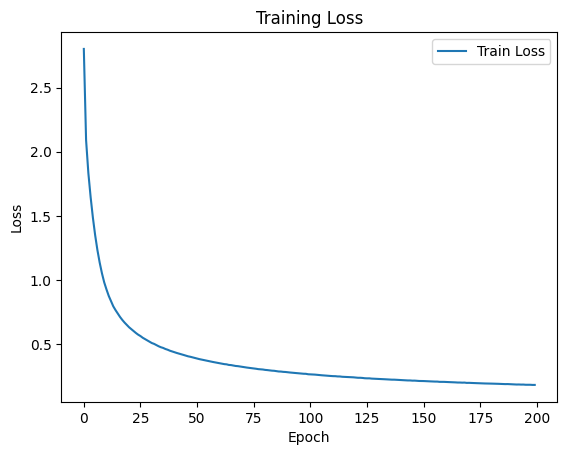

In [15]:
# Plot epoch-wise training loss
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

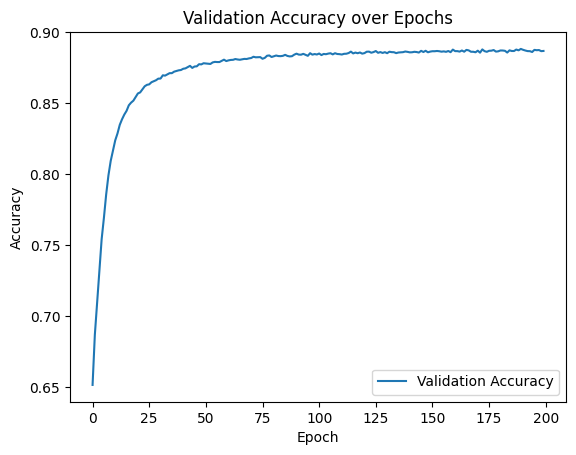

In [16]:
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()

In [17]:
# Save the model
torch.save(model.state_dict(),'transformer_model_2.pth')

In [18]:
# Load the state dictionary from the saved file

# model.load_state_dict(torch.load('transformer_model.pth'))


Test_accuracy = compute_accuracy(model, dataloaders.test_loader)

print(f"Test Accuracy: {Test_accuracy:.5f}")

Test Accuracy: 0.88582


In [19]:
# Evaluate on test set
test_bleu_score = evaluate(model, dataloaders.test_loader,20)
print(f"Test BLEU Score: {test_bleu_score:.4f}")

src:  ! I go there every year. "
trg:  J ' y vais tous les ans. "
pred: ! J ' y vais chaque année. "
src:  ! We often eat raw fish. "
trg:  Nous mangeons souvent du poisson cru. "
pred: ! Nous mangeons souvent du poisson cru. "
src:  ! I ' m sorry I hurt Tom. "
trg:  Je suis désolé d ' avoir blessé Tom. "
pred: ! Je suis désolé d ' avoir fait du mal à Tom. "
Test BLEU Score: 46.6095
